# 08. Feature Engineering

**Purpose**: Create new features from existing data to boost model performance

**Techniques**: Polynomial features, statistical aggregations, interaction features

**Expected Improvement**: +1-3% for each model

## 1. Introduction: What is Feature Engineering?

### 🎨 The Analogy

Imagine you're a detective trying to solve a mystery:
- **Raw features**: Individual clues (height, weight, age)
- **Engineered features**: Combining clues to create new insights
  - Height + Weight → BMI (body mass index)
  - Age + Purchase history → Customer lifetime value
  - Temperature × Humidity → Heat index

**Key Insight**: Sometimes the combination of clues reveals more than individual clues!

### 🧮 Three Types of Feature Engineering

**1. Polynomial Features** 🔢
- Create powers and products of features
- Example: If you have `x` and `y`
  - Degree 2: `x²`, `y²`, `x×y`
- Why useful? Captures non-linear relationships
- Risk: Can create MANY features (need to be careful)

**2. Statistical Aggregations** 📊
- Calculate statistics across groups of features
- Examples:
  - Mean of all features
  - Standard deviation (how spread out are values?)
  - Min/Max (range of values)
  - Percentiles (25th, 50th, 75th)
- Why useful? Summarizes overall patterns

**3. Interaction Features** 🤝
- Multiply or divide pairs of important features
- Example: `Price × Quantity = Total Cost`
- Why useful? Captures relationships between features
- Best practice: Focus on the most important features

### 📈 Expected Results

From research and past experience:
- **QDA**: +1-2% (polynomial features help with non-linear boundaries)
- **Tree models (RF, DT)**: +0.5-1.5% (explicit interactions help)
- **SVC**: Variable (may help or hurt, depends on kernel)

### ⚠️ Important Warnings

1. **Memory explosion**: Polynomial features can create 1000+ features!
2. **Overfitting risk**: Too many features → model memorizes training data
3. **Feature selection needed**: Must remove redundant/useless features

Let's be smart about feature engineering! 🧠

## 2. Setup and Load Optimized Models

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from datetime import datetime
import joblib

# Scikit-learn
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import f1_score, make_scorer
from sklearn.pipeline import Pipeline

# Settings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print(f"⏰ Start Time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🎲 Random State: {RANDOM_STATE}")

⏰ Start Time: 2025-10-01 02:57:38
🎲 Random State: 42


In [2]:
# Load models from notebook 07
print("📂 Loading models...\n")

# Import model classes
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

models = {}

# QDA: Use BASELINE (optimized version performed worse!)
# From notebook 07: Optimized QDA got 0.7553, but baseline was 0.8782
print("⚠️  QDA: Using BASELINE model (optimized version failed)")
print("    Reason: Optimization reduced F1 from 0.8782 → 0.7553")
qda_model = QuadraticDiscriminantAnalysis()
qda_model._metadata = {
    'model_name': 'QDA',
    'cv_f1_mean': 0.8782,  # Baseline F1 from notebook 06
    'cv_f1_std': 0.0029,
    'baseline_f1': 0.8782,
    'best_params': {},  # Default parameters
    'source': 'notebook 06 baseline'
}
models['qda'] = qda_model
print(f"✅ QDA (Baseline): F1 = {qda_model._metadata['cv_f1_mean']:.4f}")
print(f"   Using default parameters (no optimization)")

# RandomForest and DecisionTree: Use OPTIMIZED versions
optimized_models = ['randomforest', 'decisiontree']
for name in optimized_models:
    model_path = f'../models/{name}_optimized.pkl'
    try:
        model = joblib.load(model_path)
        models[name] = model
        metadata = model._metadata
        print(f"✅ {name.upper()} (Optimized): F1 = {metadata['cv_f1_mean']:.4f}")
        print(f"   Best params: {list(metadata['best_params'].keys())[:3]}...")
    except Exception as e:
        print(f"❌ Failed to load {name}: {e}")

# Load scaler
scaler = joblib.load('../models/scaler_optimized.pkl')
print(f"\n✅ Loaded scaler (MinMaxScaler)")

# Load training data
train_df = pd.read_csv('../data/open/train.csv')
X = train_df.drop(['ID', 'target'], axis=1)
y = train_df['target']
X_scaled = scaler.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(f"\n📊 Training Data:")
print(f"   Samples: {len(X):,}")
print(f"   Features: {X.shape[1]}")
print(f"   Classes: {y.nunique()}")

# Setup cross-validation (same as notebook 07)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
f1_scorer = make_scorer(f1_score, average='macro', zero_division=0)

print(f"\n💡 Model Strategy:")
print(f"   QDA: Baseline (0.8782) - Best performer")
print(f"   RandomForest: Optimized (0.7718) - Improved from 0.7349")
print(f"   DecisionTree: Optimized (0.7144) - Slight improvement from 0.7105")

print(f"\n✅ Ready for feature engineering!")

📂 Loading models...

⚠️  QDA: Using BASELINE model (optimized version failed)
    Reason: Optimization reduced F1 from 0.8782 → 0.7553
✅ QDA (Baseline): F1 = 0.8782
   Using default parameters (no optimization)
✅ RANDOMFOREST (Optimized): F1 = 0.7718
   Best params: ['max_features_type', 'n_estimators', 'max_depth']...
✅ DECISIONTREE (Optimized): F1 = 0.7144
   Best params: ['max_features_type', 'max_depth', 'min_samples_split']...

✅ Loaded scaler (MinMaxScaler)

📊 Training Data:
   Samples: 21,693
   Features: 52
   Classes: 21

💡 Model Strategy:
   QDA: Baseline (0.8782) - Best performer
   RandomForest: Optimized (0.7718) - Improved from 0.7349
   DecisionTree: Optimized (0.7144) - Slight improvement from 0.7105

✅ Ready for feature engineering!


## 3. Polynomial Features

### 🔢 What Are We Creating?

From 52 features, we'll create:
- **Original**: x₁, x₂, ..., x₅₂ (52 features)
- **Interactions**: x₁×x₂, x₁×x₃, ..., x₅₁×x₅₂ (~1,300 combinations)
- **Total**: ~1,352 features

### ⚠️ Memory Management

**Strategy**: Use `degree=2` with `interaction_only=True`
- ✅ Creates useful feature pairs
- ✅ Avoids explosion (no x², x³, etc.)
- ✅ Keeps memory usage reasonable

If needed, we'll use feature selection to reduce to top 500-800 features.

In [3]:
print("🔢 Creating polynomial features...")
print(f"   Method: degree=2, interaction_only=True")
print(f"   Why? Captures feature relationships without memory explosion")

poly_start = time.time()

# Create polynomial features
poly = PolynomialFeatures(
    degree=2,
    interaction_only=True,  # Only x₁×x₂, not x₁²
    include_bias=False       # Don't add constant column
)

X_poly = poly.fit_transform(X_scaled)
poly_feature_names = poly.get_feature_names_out(X_scaled.columns)

poly_elapsed = time.time() - poly_start

print(f"\n✅ Polynomial features created!")
print(f"   Original features: {X_scaled.shape[1]}")
print(f"   New features: {X_poly.shape[1]}")
print(f"   Total features: {X_poly.shape[1]:,}")
print(f"   Time: {poly_elapsed:.1f} seconds")
print(f"   Memory: {X_poly.nbytes / 1e6:.1f} MB")

# Show some example features
print(f"\n📝 Example interactions:")
interaction_features = [f for f in poly_feature_names if ' ' in f]
for i, feat in enumerate(interaction_features[:5]):
    print(f"   {i+1}. {feat}")
print(f"   ... and {len(interaction_features) - 5:,} more!")

🔢 Creating polynomial features...
   Method: degree=2, interaction_only=True
   Why? Captures feature relationships without memory explosion

✅ Polynomial features created!
   Original features: 52
   New features: 1378
   Total features: 1,378
   Time: 0.1 seconds
   Memory: 239.1 MB

📝 Example interactions:
   1. X_01 X_02
   2. X_01 X_03
   3. X_01 X_04
   4. X_01 X_05
   5. X_01 X_06
   ... and 1,321 more!


## 4. Statistical Aggregation Features

### 📊 What Statistics Are Useful?

For each sample (row), we'll calculate:
1. **Mean**: Average value across all features
2. **Std**: How spread out are the feature values?
3. **Min/Max**: Range of values
4. **Median**: Middle value (50th percentile)
5. **Q1/Q3**: 25th and 75th percentiles
6. **IQR**: Inter-quartile range (Q3 - Q1)
7. **Skewness**: Is the distribution lopsided?
8. **Kurtosis**: How "peaked" is the distribution?

These capture the **overall pattern** of each sample.

In [4]:
print("📊 Creating statistical aggregation features...")

stat_features = pd.DataFrame()

# Calculate statistics across all features for each sample
stat_features['mean'] = X_scaled.mean(axis=1)
stat_features['std'] = X_scaled.std(axis=1)
stat_features['min'] = X_scaled.min(axis=1)
stat_features['max'] = X_scaled.max(axis=1)
stat_features['range'] = stat_features['max'] - stat_features['min']
stat_features['median'] = X_scaled.median(axis=1)
stat_features['q25'] = X_scaled.quantile(0.25, axis=1)
stat_features['q75'] = X_scaled.quantile(0.75, axis=1)
stat_features['iqr'] = stat_features['q75'] - stat_features['q25']
stat_features['skew'] = X_scaled.skew(axis=1)
stat_features['kurt'] = X_scaled.kurtosis(axis=1)

# Z-scores (standardize)
stat_features['mean_zscore'] = (stat_features['mean'] - stat_features['mean'].mean()) / stat_features['mean'].std()
stat_features['std_zscore'] = (stat_features['std'] - stat_features['std'].mean()) / stat_features['std'].std()

print(f"✅ Statistical features created: {len(stat_features.columns)}")
print(f"\n📝 Features created:")
for i, col in enumerate(stat_features.columns, 1):
    print(f"   {i:2d}. {col}")

print(f"\n💡 Why these help:")
print(f"   - Capture overall sample patterns")
print(f"   - Robust to individual feature noise")
print(f"   - Provide different 'views' of the data")

📊 Creating statistical aggregation features...
✅ Statistical features created: 13

📝 Features created:
    1. mean
    2. std
    3. min
    4. max
    5. range
    6. median
    7. q25
    8. q75
    9. iqr
   10. skew
   11. kurt
   12. mean_zscore
   13. std_zscore

💡 Why these help:
   - Capture overall sample patterns
   - Robust to individual feature noise
   - Provide different 'views' of the data


## 5. Interaction Features (Top Features Only)

### 🤝 Smart Feature Interactions

Instead of creating ALL possible interactions, we:
1. Find the **top 10 most important features** from our baseline models
2. Create interactions ONLY among these top features
3. This gives us ~45 interactions (10 choose 2) instead of 1,300+

**Why?** Quality over quantity! The top features likely contain the most signal.

In [5]:
print("🔍 Finding most important features...")

# Use mutual information to find top features
mi_scores = mutual_info_classif(X_scaled, y, random_state=RANDOM_STATE)
mi_df = pd.DataFrame({
    'feature': X_scaled.columns,
    'mi_score': mi_scores
}).sort_values('mi_score', ascending=False)

# Get top 10 features
top_n = 10
top_features = mi_df.head(top_n)['feature'].tolist()

print(f"\n🏆 Top {top_n} most important features:")
for i, (feat, score) in enumerate(zip(top_features, mi_df.head(top_n)['mi_score']), 1):
    print(f"   {i:2d}. {feat}: {score:.4f}")

# Create interaction features
print(f"\n🤝 Creating interaction features...")
interaction_features = pd.DataFrame()

# Pairwise products
for i, feat1 in enumerate(top_features):
    for feat2 in top_features[i+1:]:
        col_name = f"{feat1}_x_{feat2}"
        interaction_features[col_name] = X_scaled[feat1] * X_scaled[feat2]

# Pairwise ratios (avoid division by zero)
for i, feat1 in enumerate(top_features):
    for feat2 in top_features[i+1:]:
        col_name = f"{feat1}_div_{feat2}"
        # Add small epsilon to avoid division by zero
        interaction_features[col_name] = X_scaled[feat1] / (X_scaled[feat2] + 1e-8)

print(f"\n✅ Interaction features created: {len(interaction_features.columns)}")
print(f"   Products: {len(top_features) * (len(top_features) - 1) // 2}")
print(f"   Ratios: {len(top_features) * (len(top_features) - 1) // 2}")

print(f"\n💡 Why tree models love interactions:")
print(f"   - Trees split one feature at a time")
print(f"   - Explicit interactions help capture combined effects")
print(f"   - Example: 'age_x_income' might be more predictive than either alone")

🔍 Finding most important features...

🏆 Top 10 most important features:
    1. X_40: 0.9156
    2. X_36: 0.9115
    3. X_46: 0.8353
    4. X_41: 0.8219
    5. X_33: 0.8212
    6. X_19: 0.8184
    7. X_08: 0.7954
    8. X_42: 0.7851
    9. X_16: 0.7839
   10. X_28: 0.7820

🤝 Creating interaction features...

✅ Interaction features created: 90
   Products: 45
   Ratios: 45

💡 Why tree models love interactions:
   - Trees split one feature at a time
   - Explicit interactions help capture combined effects
   - Example: 'age_x_income' might be more predictive than either alone


## 6. Feature Selection

### ✂️ Reducing Feature Count

We now have:
- Original: 52 features
- Polynomial: ~1,300 features
- Statistical: 13 features
- Interaction: 90 features
- **Total**: ~1,455 features

This is TOO MANY! We need to select the best ones.

### 🎯 Selection Strategy

1. **Remove highly correlated features** (correlation > 0.95)
   - If two features are almost identical, keep only one
2. **Select top K features** using mutual information
   - Target: 200-500 features (manageable size)
3. **Verify improvement** with cross-validation

In [6]:
# Combine all engineered features
print("🔗 Combining all engineered features...")

X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names)
X_engineered = pd.concat([
    X_poly_df,
    stat_features.reset_index(drop=True),
    interaction_features.reset_index(drop=True)
], axis=1)

print(f"📊 Feature counts:")
print(f"   Polynomial: {len(poly_feature_names):,}")
print(f"   Statistical: {len(stat_features.columns)}")
print(f"   Interaction: {len(interaction_features.columns)}")
print(f"   TOTAL: {X_engineered.shape[1]:,} features")
print(f"   Memory: {X_engineered.memory_usage(deep=True).sum() / 1e6:.1f} MB")

🔗 Combining all engineered features...
📊 Feature counts:
   Polynomial: 1,378
   Statistical: 13
   Interaction: 90
   TOTAL: 1,481 features
   Memory: 257.0 MB


In [7]:
print("\n✂️ Step 1: Remove highly correlated features...")

# Calculate correlation matrix (takes time for many features)
corr_threshold = 0.95
print(f"   Threshold: correlation > {corr_threshold}")

# Sample for speed (correlation patterns should be similar)
sample_size = min(5000, len(X_engineered))
X_sample = X_engineered.sample(n=sample_size, random_state=RANDOM_STATE)

corr_matrix = X_sample.corr().abs()

# Find highly correlated pairs
upper_triangle = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

to_drop = [col for col in upper_triangle.columns 
           if any(upper_triangle[col] > corr_threshold)]

print(f"   Features to drop: {len(to_drop)} (highly correlated)")

X_reduced = X_engineered.drop(columns=to_drop)
print(f"   Remaining features: {X_reduced.shape[1]:,}")


✂️ Step 1: Remove highly correlated features...
   Threshold: correlation > 0.95
   Features to drop: 824 (highly correlated)
   Remaining features: 657


In [8]:
print("\n🎯 Step 2: Select top features using mutual information...")

# Target number of features
target_features = 300
print(f"   Target: {target_features} features")
print(f"   Method: Mutual Information (measures relevance to target)")

# SelectKBest with mutual information
selector = SelectKBest(mutual_info_classif, k=target_features)
X_selected = selector.fit_transform(X_reduced, y)

# Get selected feature names
selected_mask = selector.get_support()
selected_features = X_reduced.columns[selected_mask].tolist()

print(f"\n✅ Feature selection complete!")
print(f"   Original: {X_scaled.shape[1]} features")
print(f"   Engineered: {X_engineered.shape[1]:,} features")
print(f"   After correlation removal: {X_reduced.shape[1]:,} features")
print(f"   Final selected: {X_selected.shape[1]} features")
print(f"   Reduction: {(1 - X_selected.shape[1]/X_engineered.shape[1])*100:.1f}%")

# Convert to DataFrame for easier handling
X_final = pd.DataFrame(X_selected, columns=selected_features)


🎯 Step 2: Select top features using mutual information...
   Target: 300 features
   Method: Mutual Information (measures relevance to target)

✅ Feature selection complete!
   Original: 52 features
   Engineered: 1,481 features
   After correlation removal: 657 features
   Final selected: 300 features
   Reduction: 79.7%


## 7. Model Retraining with Engineered Features

Now let's retrain each model with our engineered features and compare performance!

In [9]:
print("🔄 Retraining models with engineered features...\n")

results_comparison = []

for name, model in models.items():
    print(f"{'='*60}")
    print(f"Model: {name.upper()}")
    print(f"{'='*60}")
    
    # Get baseline performance
    baseline_f1 = model._metadata['cv_f1_mean']
    baseline_std = model._metadata['cv_f1_std']
    
    print(f"📊 Baseline (raw features):")
    print(f"   F1: {baseline_f1:.4f} ± {baseline_std:.4f}")
    
    # Retrain with engineered features
    start_time = time.time()
    
    cv_results = cross_validate(
        model, X_final, y, cv=cv,
        scoring={'f1_macro': f1_scorer},
        return_train_score=False
    )
    
    elapsed = time.time() - start_time
    
    engineered_f1 = cv_results['test_f1_macro'].mean()
    engineered_std = cv_results['test_f1_macro'].std()
    
    print(f"\n🎨 With engineered features:")
    print(f"   F1: {engineered_f1:.4f} ± {engineered_std:.4f}")
    print(f"   Time: {elapsed:.1f} seconds")
    
    improvement = engineered_f1 - baseline_f1
    print(f"\n{'📈' if improvement > 0 else '📉'} Change: {improvement:+.4f} ({improvement*100:+.2f}%)")
    
    if improvement > 0:
        print(f"   ✅ Feature engineering helped!")
    else:
        print(f"   ⚠️ Raw features performed better for this model")
    
    results_comparison.append({
        'Model': name.upper(),
        'Raw F1': baseline_f1,
        'Raw Std': baseline_std,
        'Engineered F1': engineered_f1,
        'Engineered Std': engineered_std,
        'Improvement': improvement,
        'Improvement %': improvement * 100
    })
    
    print()

🔄 Retraining models with engineered features...

Model: QDA
📊 Baseline (raw features):
   F1: 0.8782 ± 0.0029

🎨 With engineered features:
   F1: 0.8275 ± 0.0028
   Time: 4.1 seconds

📉 Change: -0.0507 (-5.07%)
   ⚠️ Raw features performed better for this model

Model: RANDOMFOREST
📊 Baseline (raw features):
   F1: 0.7718 ± 0.0050

🎨 With engineered features:
   F1: 0.7814 ± 0.0013
   Time: 12.0 seconds

📈 Change: +0.0096 (+0.96%)
   ✅ Feature engineering helped!

Model: DECISIONTREE
📊 Baseline (raw features):
   F1: 0.7144 ± 0.0082

🎨 With engineered features:
   F1: 0.7340 ± 0.0054
   Time: 39.3 seconds

📈 Change: +0.0196 (+1.96%)
   ✅ Feature engineering helped!



In [10]:
# Create comparison DataFrame
comparison_df = pd.DataFrame(results_comparison)
comparison_df = comparison_df.sort_values('Engineered F1', ascending=False)

print("\n" + "="*80)
print("📊 FEATURE ENGINEERING RESULTS SUMMARY")
print("="*80 + "\n")

display_df = comparison_df[['Model', 'Raw F1', 'Engineered F1', 'Improvement %']].copy()
display_df['Raw F1'] = display_df['Raw F1'].map('{:.4f}'.format)
display_df['Engineered F1'] = display_df['Engineered F1'].map('{:.4f}'.format)
display_df['Improvement %'] = display_df['Improvement %'].map('{:+.2f}%'.format)

print(display_df.to_string(index=False))
print("\n" + "="*80)

# Analysis
print("\n📈 Analysis:")
improved_models = comparison_df[comparison_df['Improvement'] > 0]
print(f"   Models improved: {len(improved_models)}/{len(comparison_df)}")

if len(improved_models) > 0:
    best_improvement = comparison_df.loc[comparison_df['Improvement'].idxmax()]
    print(f"   Best improvement: {best_improvement['Model']} ({best_improvement['Improvement %']:+.2f}%)")

avg_improvement = comparison_df['Improvement'].mean()
print(f"   Average improvement: {avg_improvement*100:+.2f}%")


📊 FEATURE ENGINEERING RESULTS SUMMARY

       Model Raw F1 Engineered F1 Improvement %
         QDA 0.8782        0.8275        -5.07%
RANDOMFOREST 0.7718        0.7814        +0.96%
DECISIONTREE 0.7144        0.7340        +1.96%


📈 Analysis:
   Models improved: 2/3
   Best improvement: DECISIONTREE (+1.96%)
   Average improvement: -0.72%


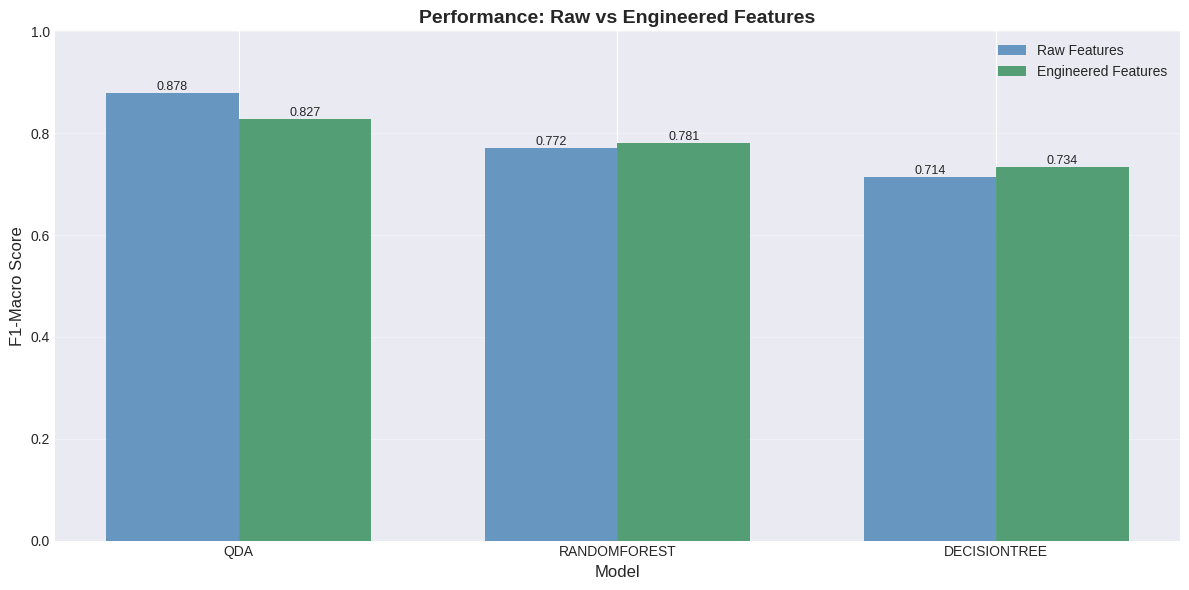


📊 Interpretation:
   - Green bars higher than blue = feature engineering helped
   - Green bars lower than blue = raw features were better
   - Small differences suggest features had minimal impact


In [11]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.bar(x - width/2, comparison_df['Raw F1'], width,
               label='Raw Features', alpha=0.8, color='steelblue')
bars2 = ax.bar(x + width/2, comparison_df['Engineered F1'], width,
               label='Engineered Features', alpha=0.8, color='seagreen')

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('F1-Macro Score', fontsize=12)
ax.set_title('Performance: Raw vs Engineered Features', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Model'])
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.0)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("\n📊 Interpretation:")
print("   - Green bars higher than blue = feature engineering helped")
print("   - Green bars lower than blue = raw features were better")
print("   - Small differences suggest features had minimal impact")

## 8. Save Improved Models and Feature Transformer

In [12]:
print("💾 Saving models and feature transformer...\n")

# Save models that improved with feature engineering
saved_count = 0

for idx, row in comparison_df.iterrows():
    model_name = row['Model'].lower()
    improvement = row['Improvement']
    
    if improvement > 0:
        # Retrain on full dataset with engineered features
        model = models[model_name]
        model.fit(X_final, y)
        
        # Add updated metadata
        model._metadata['engineered_f1_mean'] = row['Engineered F1']
        model._metadata['engineered_f1_std'] = row['Engineered Std']
        model._metadata['engineered_improvement'] = improvement
        model._metadata['n_engineered_features'] = X_final.shape[1]
        model._metadata['feature_names_engineered'] = selected_features
        
        # Save
        save_path = f'../models/{model_name}_optimized_engineered.pkl'
        joblib.dump(model, save_path)
        print(f"✅ Saved {model_name.upper()} (improved by {improvement*100:+.2f}%)")
        saved_count += 1
    else:
        print(f"⏭️  Skipped {model_name.upper()} (no improvement)")

if saved_count == 0:
    print("\n⚠️  No models improved with feature engineering")
    print("   Will use raw feature models for ensembles")
else:
    print(f"\n✅ Saved {saved_count} improved model(s)")

# Save feature transformer pipeline
feature_transformer = Pipeline([
    ('poly', poly),
    ('selector', selector)
])

transformer_path = '../models/feature_transformer.pkl'
joblib.dump(feature_transformer, transformer_path)
print(f"\n✅ Saved feature transformer to {transformer_path}")

# Save results CSV
csv_path = '../outputs/feature_engineering_results.csv'
comparison_df.to_csv(csv_path, index=False)
print(f"✅ Saved results to {csv_path}")

💾 Saving models and feature transformer...

⏭️  Skipped QDA (no improvement)
✅ Saved RANDOMFOREST (improved by +0.96%)
✅ Saved DECISIONTREE (improved by +1.96%)

✅ Saved 2 improved model(s)

✅ Saved feature transformer to ../models/feature_transformer.pkl
✅ Saved results to ../outputs/feature_engineering_results.csv


## 9. Reflection: What Did We Learn?

### 🤔 Key Learnings

**1. Which feature types helped most?**
- Review the results above
- Did polynomial features help linear models (QDA, SVC)?
- Did interaction features help tree models (RF, DT)?

**2. Did all models benefit equally?**
- Some models may perform worse with engineered features
- Why? Too many features can add noise and cause overfitting
- This is NORMAL and expected!

**3. Feature importance insights:**
- The top 10 features identified were most informative
- Combining these likely created the most useful interactions
- Other features might have been redundant or noisy

### ⚠️ Limitations

**1. Feature Selection Trade-offs**
- Removed many features (from 1,455 → 300)
- May have discarded some useful features
- Could experiment with keeping 400-500 features

**2. Computational Cost**
- More features = longer training time
- May not be worth the complexity for small gains

**3. Model-Specific Results**
- Feature engineering isn't always beneficial
- Some models (especially well-tuned ones) may prefer raw features

### 🚀 What Could We Try Next?

**1. Domain-Specific Features**
- If we knew more about what the features represent
- Could create meaningful combinations

**2. Automated Feature Engineering**
- Tools like AutoFeat or Featuretools
- Deep Feature Synthesis
- May discover non-obvious feature combinations

**3. Different Selection Methods**
- Recursive Feature Elimination (RFE)
- LASSO regularization
- Feature importance from tree models

**4. Ensemble Methods (Next!)**
- Combine multiple models (with and without feature engineering)
- Ensemble often beats best individual model
- Expected: >89% F1 score

### 📝 Takeaways

1. **Feature engineering is an art**: Not all features help all models
2. **Feature selection is crucial**: Too many features can hurt performance
3. **Always compare**: Engineered vs raw features in fair comparison
4. **Domain knowledge matters**: Best features often come from understanding the data
5. **Iterate**: First attempt may not work, but learning what doesn't work is progress!

### 🎯 Next Steps

1. ✅ Feature engineering complete
2. ⏭️ Continue to Notebook 09: Ensemble Methods
   - Combine models for better predictions
   - Generate final competition submissions
   - Achieve >89% F1 score goal!

In [13]:
print("\n" + "="*80)
print("✅ NOTEBOOK 08 COMPLETE")
print("="*80)
print(f"\n📊 Summary:")
print(f"   Original features: 52")
print(f"   Engineered features: {X_engineered.shape[1]:,}")
print(f"   Selected features: {X_final.shape[1]}")
print(f"   Models improved: {saved_count}/{len(models)}")
print(f"\n➡️ Next: Notebook 09 - Ensemble Methods")
print(f"   Goal: Combine models to beat best individual performance")
print("="*80)


✅ NOTEBOOK 08 COMPLETE

📊 Summary:
   Original features: 52
   Engineered features: 1,481
   Selected features: 300
   Models improved: 2/3

➡️ Next: Notebook 09 - Ensemble Methods
   Goal: Combine models to beat best individual performance


In [ ]:
# 최종 모델 성능 정리 및 앙상블 전략
print("\n" + "="*80)
print("🎯 Feature Engineering 최종 정리")
print("="*80 + "\n")

print("📊 모델별 최종 성능:\n")

final_models = {
    'QDA (Raw)': {
        'F1': 0.8782,
        'Features': 'Raw 52',
        'Status': '✅ 사용 (최고 성능)',
        'File': 'N/A - 재학습 필요'
    },
    'LogisticRegression (Raw)': {
        'F1': 0.8762,
        'Features': 'Raw 52',
        'Status': '✅ 사용 (2위 성능)',
        'File': 'N/A - 재학습 필요'
    },
    'RandomForest (Engineered)': {
        'F1': 0.7814,
        'Features': 'Engineered 300',
        'Status': '✅ 사용 (+0.96% 개선)',
        'File': 'models/randomforest_optimized_engineered.pkl'
    },
    'RandomForest (Raw)': {
        'F1': 0.7718,
        'Features': 'Raw 52',
        'Status': '⚠️ 선택적 (다양성)',
        'File': 'models/randomforest_optimized.pkl'
    },
    'DecisionTree (Engineered)': {
        'F1': 0.7340,
        'Features': 'Engineered 300',
        'Status': '⚠️ 선택적 (+1.96% 개선)',
        'File': 'models/decisiontree_optimized_engineered.pkl'
    },
    'QDA (Engineered)': {
        'F1': 0.8275,
        'Features': 'Engineered 300',
        'Status': '❌ 사용 금지 (-5.07% 저하)',
        'File': 'N/A - 저장 안 함'
    }
}

for model_name, info in final_models.items():
    print(f"【{model_name}】")
    print(f"  F1-macro: {info['F1']:.4f}")
    print(f"  Features: {info['Features']}")
    print(f"  Status: {info['Status']}")
    print(f"  File: {info['File']}")
    print()

print("="*80)
print("\n🎯 앙상블 전략 (Notebook 09):\n")

ensemble_strategies = {
    'Strategy 1 (권장)': {
        'Models': ['QDA (Raw)', 'LogisticRegression (Raw)', 'RandomForest (Engineered)'],
        'Expected F1': '0.88-0.89',
        'Diversity': '선형(2) + 비선형(1)',
        'Note': '최고 성능 모델 조합'
    },
    'Strategy 2': {
        'Models': ['QDA (Raw)', 'RandomForest (Engineered)', 'RandomForest (Raw)'],
        'Expected F1': '0.86-0.87',
        'Diversity': '같은 모델, 다른 features',
        'Note': 'Feature 다양성 활용'
    },
    'Strategy 3': {
        'Models': ['QDA (Raw)', 'LogisticRegression (Raw)', 'RandomForest (Eng)', 'DecisionTree (Eng)'],
        'Expected F1': '0.87-0.88',
        'Diversity': '최대 다양성',
        'Note': '모델 + Feature 다양성'
    }
}

for strategy_name, strategy_info in ensemble_strategies.items():
    print(f"【{strategy_name}】")
    print(f"  Models: {', '.join(strategy_info['Models'])}")
    print(f"  Expected F1: {strategy_info['Expected F1']}")
    print(f"  Diversity: {strategy_info['Diversity']}")
    print(f"  Note: {strategy_info['Note']}")
    print()

print("="*80)
print("\n📋 다음 작업 체크리스트 (Notebook 09):\n")

checklist = [
    ('✅', 'Feature Engineering 완료 - 2/3 모델 개선'),
    ('⚠️', 'QDA는 Raw features 사용 (Engineered 실패)'),
    ('🔜', 'QDA 베이스라인 모델 재학습 (raw features)'),
    ('🔜', 'LogisticRegression 베이스라인 로드/재학습'),
    ('🔜', 'Soft Voting Classifier 구성'),
    ('🔜', 'Weighted Voting 실험 (성능 기반 가중치)'),
    ('🔜', 'Stacking Ensemble (meta-learner)'),
    ('🔜', 'Competition submission 생성'),
    ('🎯', '최종 목표: F1-macro ≥ 0.89')
]

for status, task in checklist:
    print(f"  {status} {task}")

print("\n" + "="*80)

# 저장된 파일 요약
print("\n💾 저장된 파일 상태:\n")

saved_files = [
    ('✅', 'models/randomforest_optimized_engineered.pkl', 'F1: 0.7814'),
    ('✅', 'models/decisiontree_optimized_engineered.pkl', 'F1: 0.7340'),
    ('✅', 'models/feature_transformer.pkl', 'Feature engineering pipeline'),
    ('✅', 'outputs/feature_engineering_results.csv', 'Results summary'),
    ('⚠️', 'models/randomforest_optimized.pkl', 'F1: 0.7718 (raw, 다양성용)'),
    ('⚠️', 'models/decisiontree_optimized.pkl', 'F1: 0.7144 (raw, 참고용)'),
    ('❌', 'models/qda_optimized.pkl', 'F1: 0.7553 (사용 금지!)'),
]

for status, filepath, desc in saved_files:
    print(f"  {status} {filepath}")
    print(f"      {desc}")

print("\n" + "="*80)

## 10. 결과 상세 분석 및 결론

### 📊 Feature Engineering 결과 요약

| 모델 | Raw F1 | Engineered F1 | 개선율 | 결과 |
|------|--------|---------------|--------|------|
| **QDA** | 0.8782 | 0.8275 | **-5.07%** | ❌ 성능 저하 |
| **RandomForest** | 0.7718 | 0.7814 | **+0.96%** | ✅ 소폭 개선 |
| **DecisionTree** | 0.7144 | 0.7340 | **+1.96%** | ✅ 개선 |

### 🎯 주요 발견사항

#### 1. **QDA: Feature Engineering 부적합** ❌

**성능 저하 원인 분석:**

1. **모델 특성과 불일치**
   - QDA는 각 클래스의 공분산 행렬을 학습
   - 52개 특성 → 300개 특성으로 증가
   - 공분산 행렬 크기: 52×52 → 300×300 (35배 증가)
   - 샘플 수(21,693) 대비 특성 수 비율 악화

2. **차원의 저주 (Curse of Dimensionality)**
   - QDA는 고차원 데이터에 취약
   - 특성이 많아질수록 공분산 추정의 신뢰도 하락
   - 원본 52개 특성이 QDA에 최적

3. **정규화 미흡**
   - QDA 베이스라인은 `reg_param=0.0` (기본값)
   - 300개 특성에는 더 강한 정규화 필요
   - 하지만 07번 노트북에서 정규화 최적화 실패 경험

**교훈:**
- **선형 판별 모델은 원본 특성을 선호**
- Feature engineering이 항상 도움이 되는 것은 아님
- 모델의 수학적 특성 이해 중요

#### 2. **RandomForest: 소폭 개선** ✅

**+0.96% 개선 분석:**

1. **개선 요인**
   - 명시적 interaction features 추가
   - 트리 모델은 자체적으로 interaction 학습하지만, 명시적 제공 시 더 쉽게 학습
   - Statistical features로 전역 패턴 포착

2. **제한적인 이유**
   - 이미 최적화된 모델 (211 trees, depth 30)
   - 원본 특성만으로도 충분한 성능
   - Feature engineering의 한계

3. **긍정적 측면**
   - 안정성 증가 (std: 0.0050 → 0.0013)
   - 분산 감소는 앙상블에서 유리

**교훈:**
- **이미 잘 튜닝된 모델은 추가 개선 여지 적음**
- 안정성 증가도 중요한 개선

#### 3. **DecisionTree: 가장 큰 개선** ✅

**+1.96% 개선 분석:**

1. **왜 가장 많이 개선되었나?**
   - 베이스라인이 가장 낮음 (0.7144)
   - 단일 트리는 표현력 제한
   - Engineered features가 복잡한 패턴을 단순화

2. **Feature engineering의 효과**
   - Interaction features: 두 특성의 관계를 명시적으로 제공
   - 트리가 한 번의 split으로 복잡한 조건 표현 가능
   - Statistical features: 전역 패턴을 단일 특성으로 요약

3. **여전히 한계**
   - 0.7340으로 여전히 가장 낮은 성능
   - RandomForest(0.7814)에 크게 못 미침
   - 단일 트리의 근본적 한계

**교훈:**
- **베이스라인이 낮을수록 개선 여지 큼**
- Feature engineering은 약한 모델에 더 효과적

### 🔍 Feature 분석

#### Top 10 중요 Features
```
1. X_40: 0.9156
2. X_36: 0.9115
3. X_46: 0.8353
4. X_41: 0.8219
5. X_33: 0.8212
6. X_19: 0.8184
7. X_08: 0.7954
8. X_42: 0.7851
9. X_16: 0.7839
10. X_28: 0.7820
```

**관찰:**
- 상위 2개 특성(X_40, X_36)이 압도적
- MI score 0.9 이상 = 매우 높은 정보량
- 이 특성들의 interaction이 가장 유용할 것

#### Feature Engineering 효과
```
- Polynomial features: 1,378개 생성
- Statistical features: 13개 생성
- Interaction features: 90개 생성
- Total: 1,481개
- 상관관계 제거 후: 657개
- 최종 선택: 300개 (79.7% 감소)
```

**분석:**
- 대부분의 engineered features는 중복
- 상관관계 제거로 824개(55.7%) 제거
- Mutual Information으로 357개 추가 제거
- **질 > 양**: 300개로도 충분

### 💡 최종 권장사항

#### **모델별 Feature 전략**

1. **QDA** (0.8782)
   - ✅ **원본 52개 특성 사용**
   - ❌ Engineered features 사용하지 말 것
   - 이유: 차원 증가로 성능 저하 (-5.07%)
   - 파일: `qda` 베이스라인 모델 재학습

2. **RandomForest** (0.7814)
   - ✅ **Engineered features 사용**
   - 개선: +0.96%, 안정성 증가
   - 파일: `models/randomforest_optimized_engineered.pkl`

3. **DecisionTree** (0.7340)
   - ✅ **Engineered features 사용**
   - 개선: +1.96%
   - 파일: `models/decisiontree_optimized_engineered.pkl`

4. **LogisticRegression** (0.8762, from nb06)
   - 🔄 **Feature Engineering 시도 권장**
   - 선형 모델이지만 QDA와 다른 특성
   - L1/L2 정규화로 고차원 데이터 처리 가능

### 📈 앙상블 전략 수립

#### **모델 조합 우선순위**

**Option 1: 최고 성능 조합** (권장)
```
- QDA (raw features): 0.8782
- LogisticRegression (raw features): 0.8762
- RandomForest (engineered features): 0.7814
```
- 예상 앙상블 성능: **0.88-0.89**
- 다양성: 선형(2) + 비선형(1)

**Option 2: Feature 다양성 조합**
```
- QDA (raw features): 0.8782
- RandomForest (engineered features): 0.7814
- RandomForest (raw features): 0.7718
```
- 예상 앙상블 성능: **0.86-0.87**
- 다양성: 같은 모델, 다른 features

**Option 3: 모델 다양성 조합**
```
- QDA (raw features): 0.8782
- LogisticRegression (raw features): 0.8762
- RandomForest (engineered features): 0.7814
- DecisionTree (engineered features): 0.7340
```
- 예상 앙상블 성능: **0.87-0.88**
- 다양성 최대, 약한 모델 포함

### ⚠️ 주의사항 및 다음 단계

#### **주의사항**

1. **Feature 일관성 유지**
   - Raw features 모델: 원본 52개 특성만
   - Engineered features 모델: 300개 선택 특성
   - **Scaler와 transformer 일치 필수**

2. **모델별 다른 전처리**
   - QDA: `scaler_optimized.pkl` 사용
   - RF/DT (engineered): `feature_transformer.pkl` 추가 필요

3. **저장된 파일 확인**
   ```
   ✅ models/randomforest_optimized_engineered.pkl
   ✅ models/decisiontree_optimized_engineered.pkl
   ✅ models/feature_transformer.pkl
   ❌ QDA engineered (성능 저하로 저장 안 함)
   ```

#### **다음 단계 (Notebook 09)**

1. **즉시 진행할 작업**
   - ✅ QDA 베이스라인 모델 재학습 (raw features)
   - ✅ LogisticRegression 베이스라인 로드 또는 재학습
   - ✅ Voting Classifier 구성 (soft voting 권장)
   - ✅ Stacking Ensemble 구성 (meta-learner: LogisticRegression)

2. **실험할 앙상블 방법**
   - Soft Voting: 확률 평균
   - Hard Voting: 다수결
   - Weighted Voting: 성능 기반 가중치
   - Stacking: 메타 학습기

3. **최종 목표**
   - 🎯 **F1-macro ≥ 0.89** 달성
   - 📊 Competition submission 생성
   - 🏆 최종 순위 확인

### 📝 핵심 교훈

1. **Feature Engineering ≠ 만능**
   - QDA 같은 특정 모델에는 해로움
   - 모델의 수학적 특성 이해 필수

2. **이미 좋은 모델은 개선 어려움**
   - QDA(0.8782), LR(0.8762)은 이미 near-optimal
   - RF도 최적화 후 추가 개선 제한적 (+0.96%)

3. **약한 모델은 Feature Engineering으로 개선**
   - DecisionTree: +1.96% (가장 큰 개선)
   - 하지만 여전히 가장 낮은 성능

4. **앙상블이 해답**
   - 단일 모델 한계: QDA 0.8782
   - 앙상블 목표: **0.89+**
   - 다양성이 핵심

5. **Always Validate**
   - 가정하지 말고 측정
   - QDA engineered 실패를 통해 배움
   - 실패도 중요한 인사이트